# MainQuest 06. House Prices_회귀_집값 예측

# 진행
1. 데이터 & 라이브러리 불러오기
2. 데이터 탐색 및 전처리
3. 데이터 스케일링 & 피처 엔지니어링
4. 학습과 테스트 데이터 분리
5. 모델 학습
    - 선형 회귀 모델
    - 회귀 트리 모델
    - 스태킹 앙상블 모델
6. 모델별 스코어
7. 최종 제출

# 1. 데이터 & 라이브러리 불러오기

In [101]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import StackingRegressor

In [102]:
house_df = pd.read_csv('./data/HousePrices_train.csv')
test = pd.read_csv('./data/HousePrices_test.csv')
train = house_df.copy()
train.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,968,20,RL,NaN,7390,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,7,2008,WD,Normal,135000
1,739,90,RL,60.0,10800,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,3,2009,WD,Alloca,179000
2,696,20,RL,54.0,13811,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,7,2006,WD,Normal,176000


In [103]:
print(train.shape)
print(test.shape)

(1168, 81)
(292, 80)


# 2. 데이터 탐색 및 전처리

## 1) 데이터 확인

In [104]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1168 entries, 0 to 1167
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1168 non-null   int64  
 1   MSSubClass     1168 non-null   int64  
 2   MSZoning       1168 non-null   object 
 3   LotFrontage    950 non-null    float64
 4   LotArea        1168 non-null   int64  
 5   Street         1168 non-null   object 
 6   Alley          70 non-null     object 
 7   LotShape       1168 non-null   object 
 8   LandContour    1168 non-null   object 
 9   Utilities      1168 non-null   object 
 10  LotConfig      1168 non-null   object 
 11  LandSlope      1168 non-null   object 
 12  Neighborhood   1168 non-null   object 
 13  Condition1     1168 non-null   object 
 14  Condition2     1168 non-null   object 
 15  BldgType       1168 non-null   object 
 16  HouseStyle     1168 non-null   object 
 17  OverallQual    1168 non-null   int64  
 18  OverallC

In [105]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
Id,1168.0,728.528253,415.393477,1.0,373.75,720.5,1086.25,1460.0
MSSubClass,1168.0,56.977740,42.290680,20.0,20.00,50.0,70.00,190.0
LotFrontage,950.0,70.058947,24.762405,21.0,59.00,69.0,80.00,313.0
LotArea,1168.0,10336.357877,8784.854640,1300.0,7560.00,9446.0,11601.50,164660.0
OverallQual,1168.0,6.105308,1.373032,1.0,5.00,6.0,7.00,10.0
OverallCond,1168.0,5.595890,1.127388,1.0,5.00,5.0,6.00,9.0
YearBuilt,1168.0,1971.201199,30.362445,1872.0,1954.00,1972.5,2001.00,2010.0
YearRemodAdd,1168.0,1985.021404,20.693264,1950.0,1966.75,1994.0,2004.00,2010.0
MasVnrArea,1160.0,102.938793,176.142597,0.0,0.00,0.0,168.00,1170.0
BsmtFinSF1,1168.0,442.928938,462.364719,0.0,0.00,374.5,714.50,5644.0


In [106]:
# 데이터 세트의 전체 크기
print('데이터 세트의 Shape:', train.shape)
# 전체 컬럼의 타입 
print('\n전체 feature 들의 type \n',train.dtypes.value_counts())
# 결측치 컬럼
null_count = train.isnull().sum()
null_percent = (null_count / len(train)) * 100

# 결측치가 있는 컬럼만 추출해 새로운 DataFrame 생성
null_summary = pd.DataFrame({
    'Missing Values': null_count,
    'Missing Rate (%)': null_percent
})

# 결측치가 1개 이상인 컬럼만 추출하고, 퍼센트 기준 내림차순 정렬
null_summary = null_summary[null_summary['Missing Values'] > 0] \
                    .sort_values(by='Missing Rate (%)', ascending=False)

# 출력
print("\n결측치 요약:\n", null_summary)

데이터 세트의 Shape: (1168, 81)

전체 feature 들의 type 
 object     43
int64      35
float64     3
Name: count, dtype: int64

결측치 요약:
               Missing Values  Missing Rate (%)
PoolQC                  1162         99.486301
MiscFeature             1120         95.890411
Alley                   1098         94.006849
Fence                    941         80.565068
MasVnrType               694         59.417808
FireplaceQu              545         46.660959
LotFrontage              218         18.664384
GarageType                69          5.907534
GarageYrBlt               69          5.907534
GarageFinish              69          5.907534
GarageQual                69          5.907534
GarageCond                69          5.907534
BsmtFinType2              24          2.054795
BsmtExposure              24          2.054795
BsmtFinType1              23          1.969178
BsmtCond                  23          1.969178
BsmtQual                  23          1.969178
MasVnrArea                 8

- 데이터 양에 비해 Null 값이 많은 피처들이 있어 결측치 확인하고 처리가 필요해보임.
- 문자형과 수치형 데이터가 모두 있어 피처 엔지니어링이 필요해보임.

## 2) 타겟 값의 분포 확인

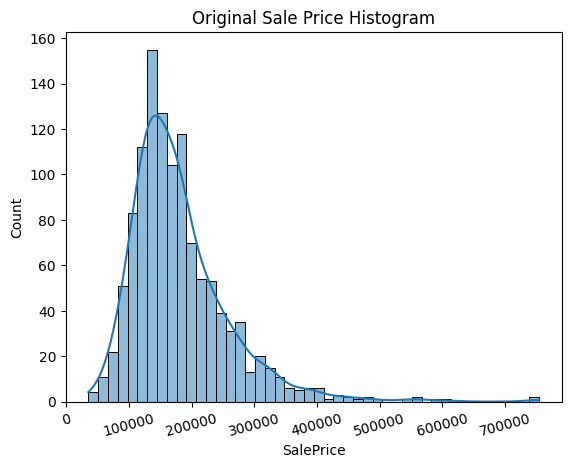

In [107]:
# 타깃 값의 분포도 확인
plt.title('Original Sale Price Histogram')
plt.xticks(rotation=15)
sns.histplot(train['SalePrice'], kde=True)
plt.show()

데이터 값의 분포가 중심에서 왼쪽으로 치우친 형태로, 정규 분포에서 벗어나 있음.  
→ 로그 변환을 적용하여 정규 분포 형태로 변환.  
** 로그 변환한 결과값을 기반으로 학습한 뒤, 예측 시에는 다시 결과값을 expm1() 으로 환원

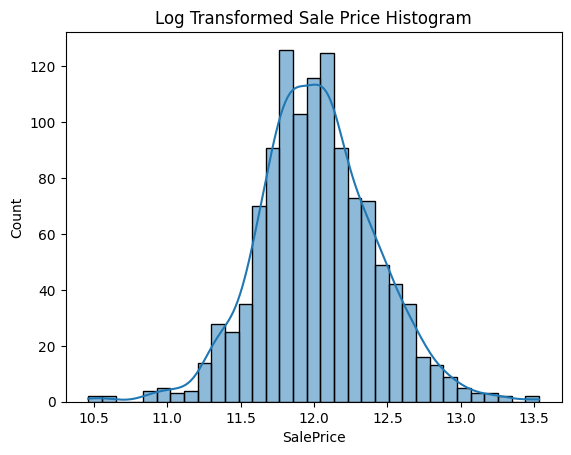

In [108]:
plt.title('Log Transformed Sale Price Histogram')
log_SalePrice = np.log1p(train['SalePrice'])
sns.histplot(log_SalePrice, kde=True)
plt.show()

In [109]:
# SalePrice 로그 변환
original_SalePrice = train['SalePrice']
train['SalePrice'] = np.log1p(train['SalePrice'])

## 3) 결측치 처리

In [110]:
# # 결측치 처리 이전에 데이터프레임 복사
# train_null = train.copy()
# # Null 이 너무 많은 컬럼들과 불필요한 컬럼 삭제 (50%에 근접하거나 그 이상의 결측치)
# train_null.drop(['Id','PoolQC' , 'MiscFeature', 'MasVnrType', 'Alley', 'Fence','FireplaceQu'], axis=1 , inplace=True)
# # Drop 하지 않는 수치형 Null컬럼들은 중앙값으로 대체
# num_cols = train_null.select_dtypes(include=['number']).columns
# train_null[num_cols] = train_null[num_cols].fillna(train_null[num_cols].median())

# # Null 값이 있는 피처명과 타입을 추출
# null_column_count = ttrain_null.isnull().sum()[train_null.isnull().sum() > 0]
# print('## Null 피처의 Type :\n', train_null.dtypes[null_column_count.index])

In [111]:
# # 문자형 타입에만 결측치가 남았으므로, 범주형 컬럼에는 최빈값 대체
# cat_cols = train_null.select_dtypes(include=['object', 'category']).columns

# # 각 범주형 컬럼의 결측치를 최빈값으로 대체
# for col in cat_cols:
#     if train_null[col].isnull().any():  # 결측치가 있는 컬럼만 처리
#         mode_val = train_null[col].mode()[0]
#         train_null[col].fillna(mode_val, inplace=True)

# # Null 값이 있는 피처명과 타입을 추출
# null_column_count = train_null.isnull().sum()[train_null.isnull().sum() > 0]
# print('## Null 피처의 Type :\n', train_null.dtypes[null_column_count.index])

In [112]:
# test 데이터셋에도 적용해야 하므로 함수로 정의
def preprocess_null(df):
    df = df.copy()

    # Null이 너무 많은 컬럼들과 불필요한 컬럼 삭제 (50%에 근접하거나 그 이상의 결측치)
    cols_drop = ['Id', 'PoolQC', 'MiscFeature', 'MasVnrType', 'Alley', 'Fence', 'FireplaceQu']
    df = df.drop(columns=[col for col in cols_drop if col in df.columns])
    
    # 남아있는 수치형 컬럼의 결측치 -> 중앙값 대체
    num_cols = df.select_dtypes(include=['number']).columns
    median_vals = df[num_cols].median()
    df[num_cols] = df[num_cols].fillna(median_vals)

    # 범주형 컬럼의 결측치 -> 'None' 대체
    cat_cols = df.select_dtypes(include=['object']).columns
    for col in cat_cols:
        if df[col].isnull().any():
            df[col] = df[col].fillna('None')

    return df

In [113]:
# train과 test 데이터에 적용
train = preprocess_null(train)
test = preprocess_null(test)

In [114]:
# Null 값이 있는 피처명과 타입을 추출
null_column_count = train.isnull().sum()[train.isnull().sum() > 0]
print('## Null 피처의 Type :\n', train.dtypes[null_column_count.index])

# null_column_count = test.isnull().sum()[test.isnull().sum() > 0]
# print('## Null 피처의 Type :\n', test.dtypes[null_column_count.index])

## Null 피처의 Type :
 Series([], dtype: object)


In [115]:
print(train.shape)
print(test.shape)

(1168, 74)
(292, 73)


In [116]:
house_df.info()  # 원본은 그대로 두고 train 데이터 사용

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1168 entries, 0 to 1167
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1168 non-null   int64  
 1   MSSubClass     1168 non-null   int64  
 2   MSZoning       1168 non-null   object 
 3   LotFrontage    950 non-null    float64
 4   LotArea        1168 non-null   int64  
 5   Street         1168 non-null   object 
 6   Alley          70 non-null     object 
 7   LotShape       1168 non-null   object 
 8   LandContour    1168 non-null   object 
 9   Utilities      1168 non-null   object 
 10  LotConfig      1168 non-null   object 
 11  LandSlope      1168 non-null   object 
 12  Neighborhood   1168 non-null   object 
 13  Condition1     1168 non-null   object 
 14  Condition2     1168 non-null   object 
 15  BldgType       1168 non-null   object 
 16  HouseStyle     1168 non-null   object 
 17  OverallQual    1168 non-null   int64  
 18  OverallC

## 4) 이상치 처리

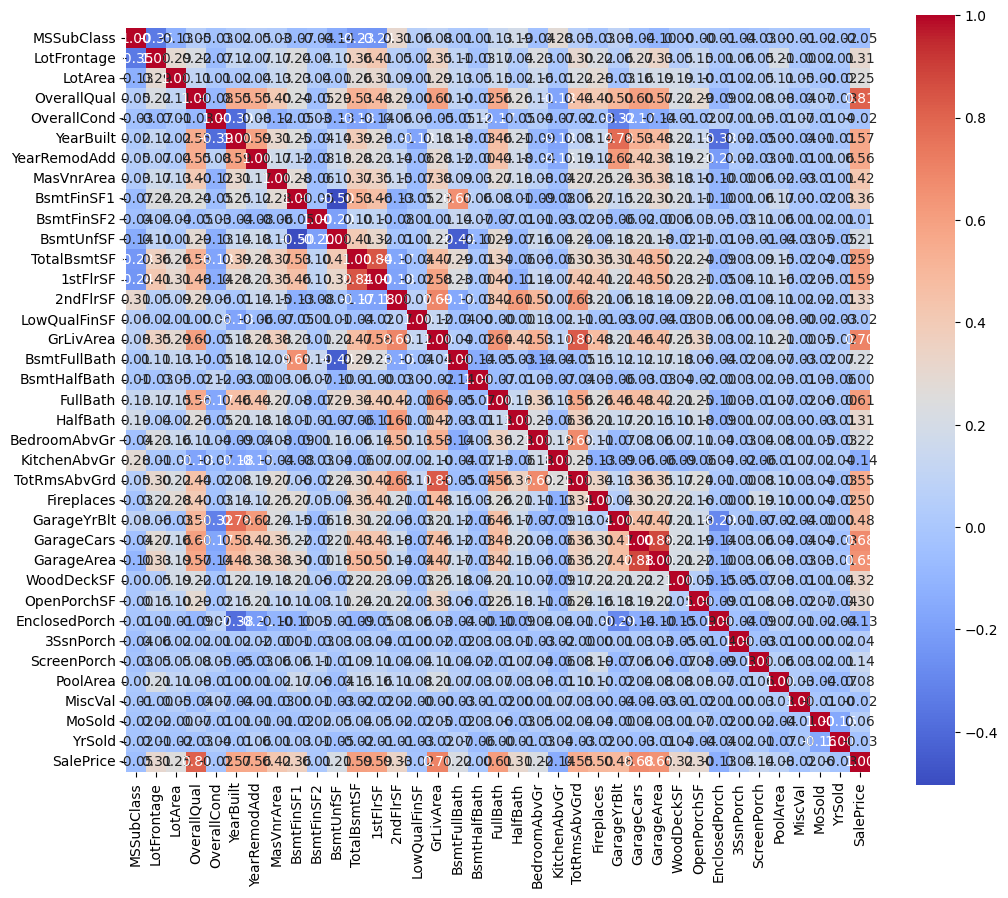

In [117]:
# 타겟과 상관관계가 높은 변수 찾기
import matplotlib.pyplot as plt
import seaborn as sns

# 수치형 컬럼만 추출한 상관관계 행렬
corr_matrix = train.corr(numeric_only=True)

# 히트맵 시각화
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True, cbar=True)
plt.show()

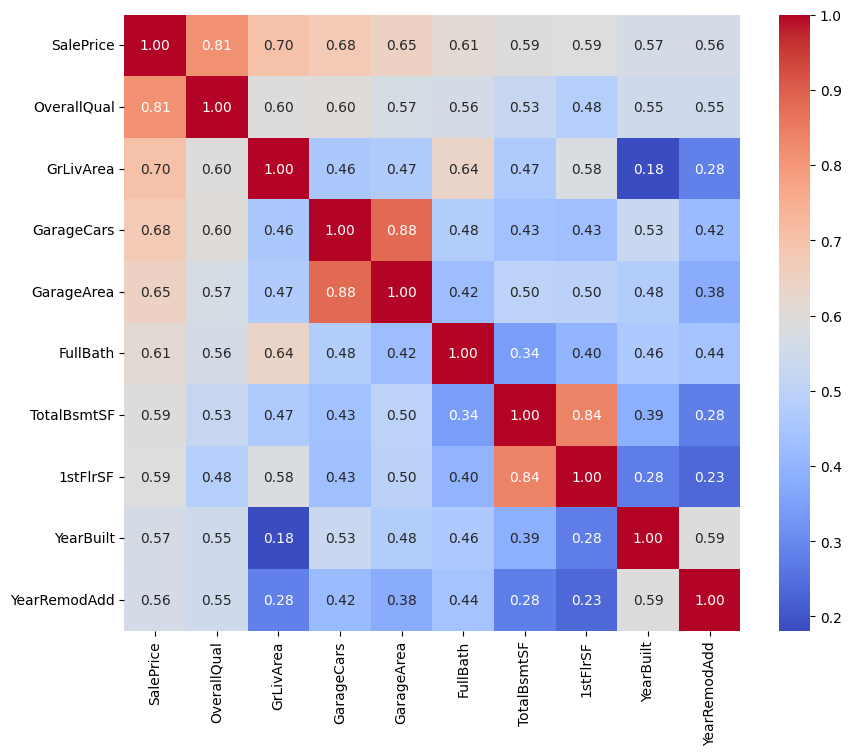

In [118]:
# SalePrice와의 상관계수 상위 10개 피처만 시각화
top_corr_features = corr_matrix['SalePrice'].abs().sort_values(ascending=False).head(10).index

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix.loc[top_corr_features, top_corr_features], 
            annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.show()

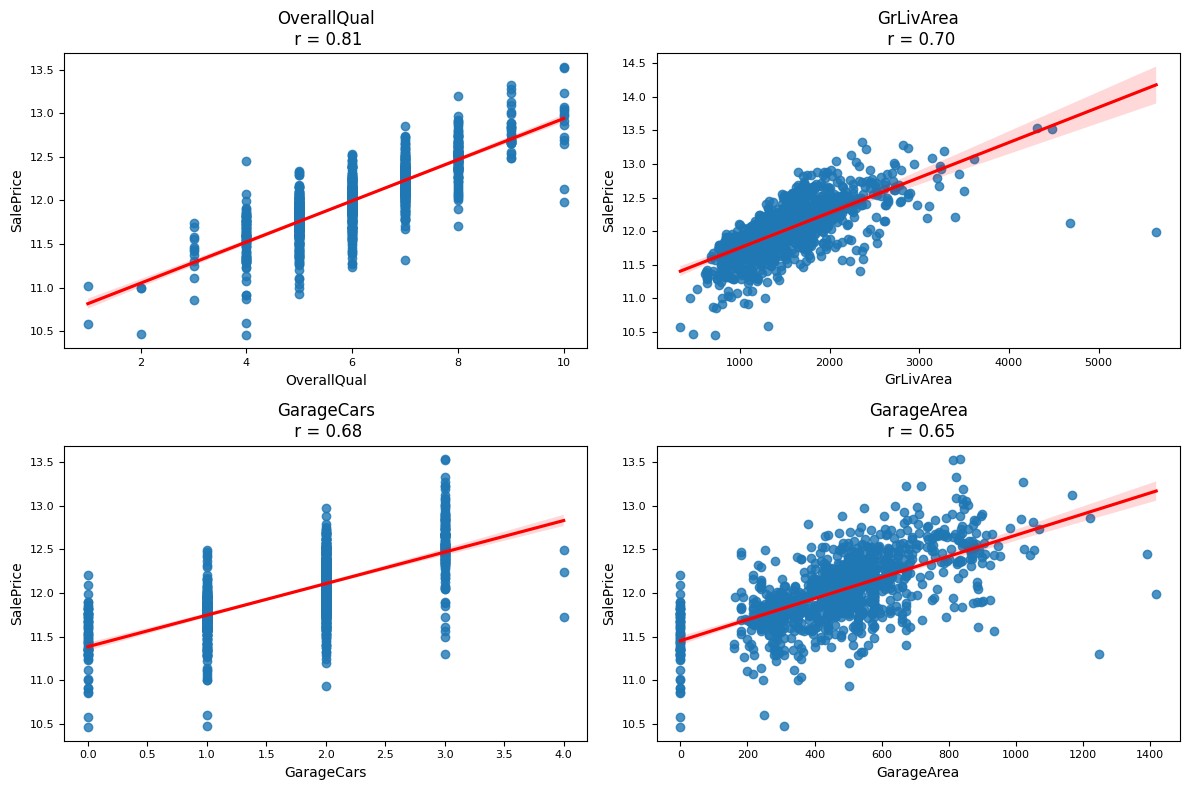

In [119]:
# 타겟과 상관관게 높은 상위 4개 이상치 데이터 확인
top4_features = ['OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea']

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
axes = axes.flatten()

for i, col in enumerate(top4_features):
    sns.regplot(x=col, y='SalePrice', data=train, ax=axes[i], line_kws={'color':'red'})
    r = train[[col, 'SalePrice']].corr().iloc[0, 1]
    axes[i].set_title(f"{col}\n r = {r:.2f}")
    axes[i].tick_params(axis='x', labelsize=8)
    axes[i].tick_params(axis='y', labelsize=8)

plt.tight_layout()
plt.show()

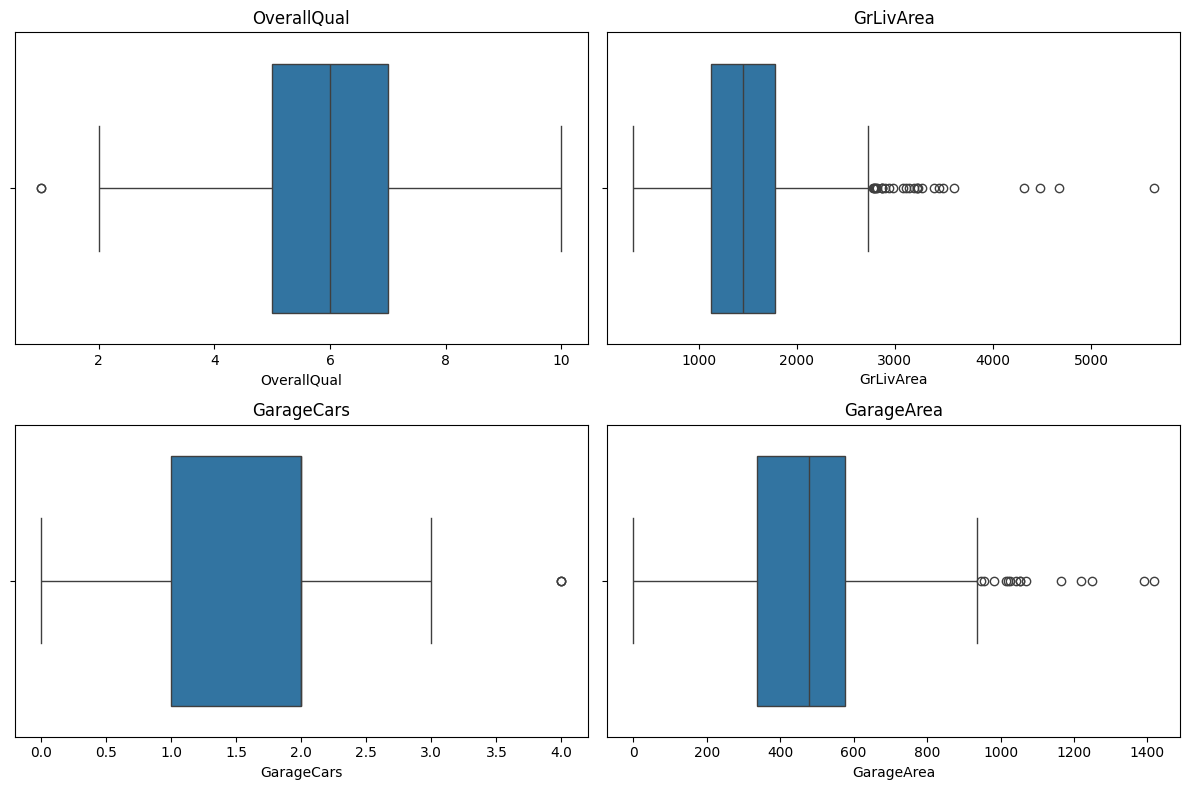

In [120]:
# 박스플롯
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
sns.boxplot(x=train['OverallQual'])
plt.title('OverallQual')

plt.subplot(2, 2, 2)
sns.boxplot(x=train['GrLivArea'])
plt.title('GrLivArea')

plt.subplot(2, 2, 3)
sns.boxplot(x=train['GarageCars'])
plt.title('GarageCars')

plt.subplot(2, 2, 4)
sns.boxplot(x=train['GarageArea'])
plt.title('GarageArea')

plt.tight_layout()
plt.show()

In [121]:
# IQR로 이상치 확인 -
def get_outliers(df=None, columns=None, weight=1.5):
    outliers = {}
    for col in columns:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        iqr_weight = iqr * weight
        
        lowest_val = q1 - iqr_weight
        highest_val = q3 + iqr_weight
        
        outliers[col] = df[(df[col] < lowest_val) | (df[col] > highest_val)].index.tolist()

    return outliers

top4_features = ['OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea']   # 4개 다 줄여보고 개수 줄이며 확인
top2_features = ['OverallQual', 'GrLivArea'] # 2개만 적용해보기
outliers = get_outliers(train, top2_features)

# 이상치 수치도 확인
for col in top2_features:
    print(f'Outliers Count{col}:', len(outliers[col]))
    print(outliers[col])

Outliers CountOverallQual: 2
[273, 864]
Outliers CountGrLivArea: 28
[64, 68, 107, 165, 267, 317, 373, 399, 408, 422, 432, 579, 647, 694, 709, 759, 776, 777, 829, 885, 913, 923, 1019, 1032, 1065, 1108, 1114, 1167]


In [122]:
# 이상치 인덱스 중복 제거해서 모으기
all_outliers = set()
for col in top2_features:
    all_outliers.update(outliers[col])

# 이상치 삭제 -> 새로운 데이터프레임으로 저장
train_clean = train.drop(index=all_outliers)

# 데이터 크기 확인
print(f'원본(결측치 처리까지 반영): {train.shape}')
print(f'이상치 제거 후: {train_clean.shape}')

원본(결측치 처리까지 반영): (1168, 74)
이상치 제거 후: (1138, 74)


In [23]:
# # 책과 같이 GrLivArea의 이상치만 제거 -> 모델 과적합 발생 
# cond1 = train['GrLivArea'] > np.log1p(4000)
# cond2 = train['SalePrice'] < np.log1p(50000)
# outlier_index = train[cond1 & cond2].index

# print('아웃라이어 레코드 index :', outlier_index.values)
# print('아웃라이어 삭제 전 house_df_ohe shape:', train.shape)
# # DataFrame의 index를 이용하여 아웃라이어 레코드 삭제.
# train_clean = train.drop(outlier_index , axis=0)
# print('아웃라이어 삭제 후 house_df_ohe shape:', train_clean.shape)

# 3. 피처 엔지니어링 & 데이터 스케일링

- 연관있어 보이는 데이터들을 묶어서 새로운 피처 만들기

In [123]:
# 마찬가지로 사용할 경우 test 데이터에도 생성 필요 
def add_features(df):
    df = df.copy()
    # 총 집의 면적 
    df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']  # LowQualFinSF는 저품질 면적이라 포함 x
    # 욕실 개수_half bath는 1/2로 계산
    df['TotalBath'] = df['BsmtFullBath'] + df['BsmtHalfBath']/2 + df['FullBath'] + df['HalfBath']/2
    # 건물 연식
    df['HouseAGe'] = df['YrSold'] - df['YearBuilt']

    # 기존 피처 삭제
    cols_to_drop = ['TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 
                    'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 
                    'YrSold', 'YearBuilt']
    df.drop(columns=cols_to_drop, inplace=True)


    return df

In [124]:
# train, test 에 적용 - 비교를 위해 별도 DataFrame
# train_add = add_features(train_clean)  # 이상치 제거하지 않은 데이터 사용

train_clean_add = add_features(train_clean)
test_add = add_features(test)

print(train_clean_add.shape)
print(test_add.shape)

(1138, 68)
(292, 67)


- 왜곡 정도가 높은 피처는 로그 변환
- 범주형 데이터 원-핫 인코딩

In [128]:
from scipy.stats import skew

# object가 아닌 숫자형 피처의 칼럼 index 객체 추출.
features_index = train_clean_add.dtypes[train_clean_add.dtypes != 'object'].index
# train_clean_add에 칼럼 index를 [ ]로 입력하면 해당하는 칼럼 데이터 세트 반환. apply lambda로 skew( ) 호출
skew_features = train_clean_add[features_index].apply(lambda x : skew(x))
# skew(왜곡) 정도가 1 이상인 칼럼만 추출.
skew_features_top = skew_features[skew_features > 1]
print(skew_features_top.sort_values(ascending=False))

PoolArea         23.940950
MiscVal          22.251642
LotArea          11.962564
LowQualFinSF     11.194473
3SsnPorch        10.894598
BsmtFinSF2        4.510154
KitchenAbvGr      4.471637
ScreenPorch       3.779032
EnclosedPorch     2.859284
MasVnrArea        2.378923
OpenPorchSF       2.141325
LotFrontage       1.968215
WoodDeckSF        1.570472
MSSubClass        1.381912
dtype: float64


In [332]:
# train_clean_add.info()

In [129]:
## 로그 변환 함수로 정의
def log_skewed_features (df, skew_threshold=1):
    # 수치형 피처만 추출
    num_features = df.select_dtypes(exclude=['object']).columns
    # 왜도 계산
    skew_features = df[num_features].apply(lambda x: skew(x))
    # 왜도가 1 이상인 컬럼만 추출
    skew_features_top = skew_features[skew_features > skew_threshold]
    print(skew_features_top.sort_values(ascending=False))

    # 로그 변환
    df[skew_features_top.index] = np.log1p(df[skew_features_top.index])
    return df

In [130]:
## 범주형 피처 원-핫 인코딩
def one_hot_encode(df):
    return pd.get_dummies(df)

In [131]:
## 데이터 처리 적용
# train 데이터
# train 데이터 처리
train_processed = log_skewed_features(train_clean_add.copy())
train_processed = one_hot_encode(train_processed)

# test 데이터 처리
test_processed = log_skewed_features(test_add.copy())
test_processed = one_hot_encode(test_processed)

print(train_processed.shape)
print(test_processed.shape)

PoolArea         23.940950
MiscVal          22.251642
LotArea          11.962564
LowQualFinSF     11.194473
3SsnPorch        10.894598
BsmtFinSF2        4.510154
KitchenAbvGr      4.471637
ScreenPorch       3.779032
EnclosedPorch     2.859284
MasVnrArea        2.378923
OpenPorchSF       2.141325
LotFrontage       1.968215
WoodDeckSF        1.570472
MSSubClass        1.381912
dtype: float64
PoolArea         17.000101
LotArea          11.678120
MiscVal           9.926571
3SsnPorch         7.427955
LowQualFinSF      7.324262
ScreenPorch       4.452703
KitchenAbvGr      4.416801
BsmtFinSF2        3.487335
MasVnrArea        3.316226
EnclosedPorch     2.828783
OpenPorchSF       1.581293
WoodDeckSF        1.508778
MSSubClass        1.464579
BsmtUnfSF         1.127580
dtype: float64
(1138, 265)
(292, 233)


In [132]:
# 컬럼 개수가 달라서 0 으로 맞춰줌
test_processed = test_processed.reindex(columns=train_processed.columns, fill_value=0)

print(train_processed.shape)
print(test_processed.shape)

(1138, 265)
(292, 265)


# 4. 학습 데이터
- 학습 데이터를 학습-테스트 데이터로 분리
- RMSE 평가 함수 생성

In [133]:
## 학습 데이터 분리
y_target = train_processed['SalePrice']
X_features = train_processed.drop('SalePrice', axis=1, inplace=False)

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

In [134]:
## RMSE 평가 함수
def get_rmse(model):
    pred = model.predict(X_test)
    pred_exp = np.expm1(pred)
    mse = mean_squared_error(np.expm1(y_test) , pred_exp)
    mse2 = mean_squared_error(y_test , pred)
    rmse = np.sqrt(mse)

    print('{0} 로그 변환된 RMSE: {1}'.format(model.__class__.__name__,np.round(np.sqrt(mse2), 3)))
    print('{0} 로그 변환해제 RMSE: {1}'.format(model.__class__.__name__,np.round(rmse, 3)))

    return rmse

def get_rmses(models):
    rmses = []
    for model in models:
        rmse = get_rmse(model)
        rmses.append(rmse)
    return rmses

# 5. 모델 학습/예측/평가

## 1) 선형 회귀 모델

In [135]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso

# LinearRegression, Ridge, Lasso 학습, 예측, 평가
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)

ridge_reg = Ridge()
ridge_reg.fit(X_train, y_train)

lasso_reg = Lasso()
lasso_reg.fit(X_train, y_train)

models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

LinearRegression 로그 변환된 RMSE: 0.127
LinearRegression 로그 변환해제 RMSE: 20204.475
Ridge 로그 변환된 RMSE: 0.123
Ridge 로그 변환해제 RMSE: 19524.898
Lasso 로그 변환된 RMSE: 0.19
Lasso 로그 변환해제 RMSE: 32389.861


[np.float64(20204.475380268967),
 np.float64(19524.89756663483),
 np.float64(32389.860763881716)]

In [136]:
## 모델별 피처의 회귀 계수 확인

# 회귀 계수 값의 상위 10개, 하위 10개의 피처명과 그 회귀 계수 값을 가지는 판다스 시리즈 객체 반환 함수
def get_top_bottom_coef(model):
    # coef_ 속성을 기반으로 Series 객체를 생성. index는 컬럼명. 
    coef = pd.Series(model.coef_, index=X_features.columns)

    # + 상위 10개 , - 하위 10개 coefficient 추출하여 반환.
    coef_high = coef.sort_values(ascending=False).head(10)
    coef_low = coef.sort_values(ascending=False).tail(10)
    return coef_high, coef_low

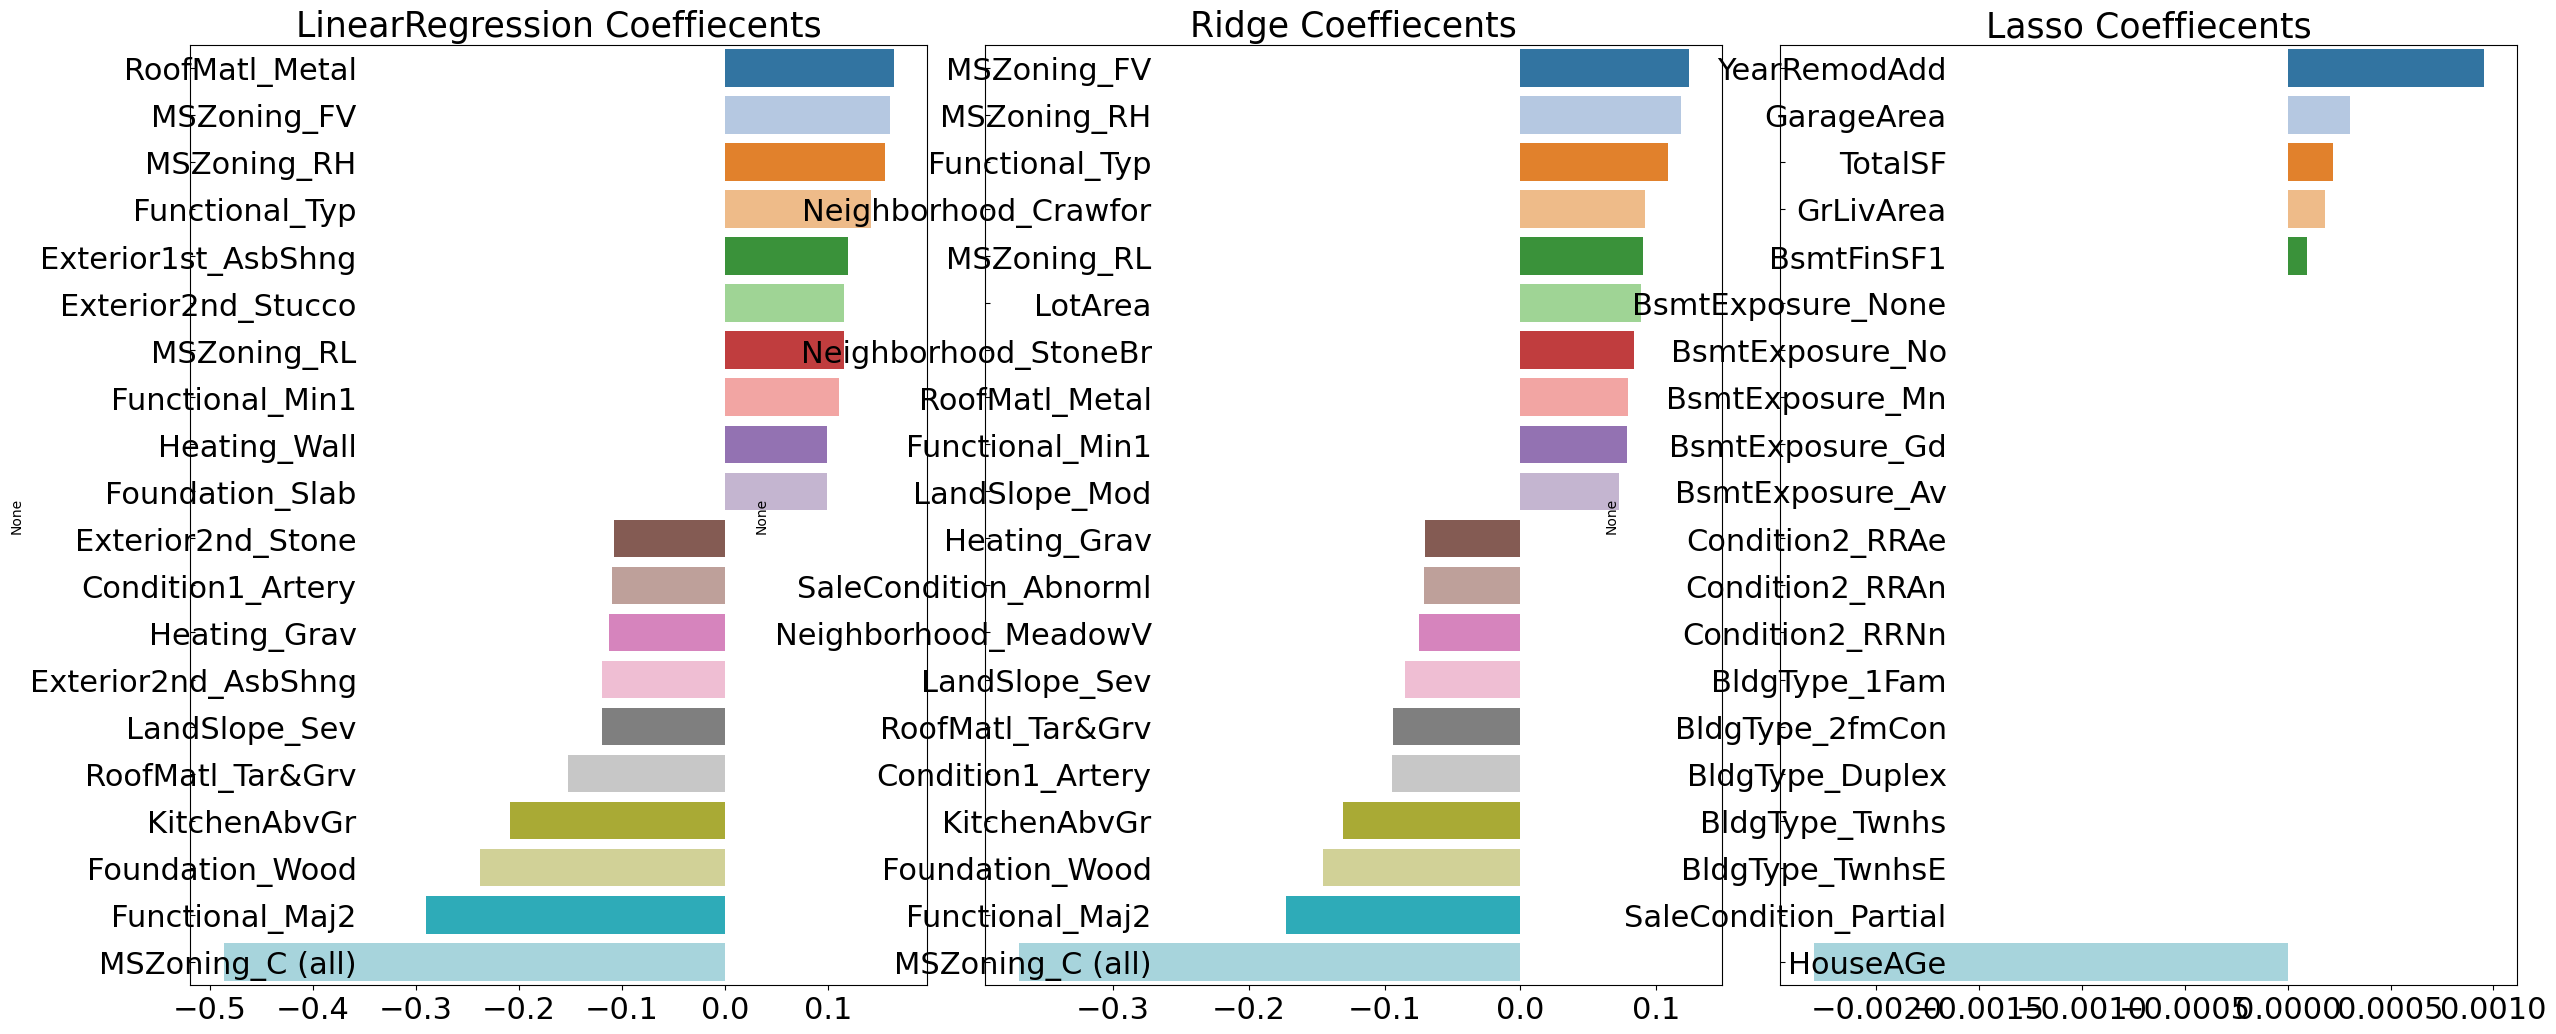

In [137]:
# 모델별 회귀 계수 시각화
def visualize_coefficient(models):
    fig, axs = plt.subplots(figsize=(24,10), nrows=1, ncols=3)
    fig.tight_layout()
    # 입력인자로 받은 list객체인 models에서 차례로 model을 추출하여 회귀 계수 시각화. 
    for i_num, model in enumerate(models):
        # 상위 10개, 하위 10개 회귀 계수를 구하고, 이를 판다스 concat으로 결합. 
        coef_high, coef_low = get_top_bottom_coef(model)
        coef_concat = pd.concat([coef_high, coef_low])
        # 순차적으로 ax subplot에 barchar로 표현. 한 화면에 표현하기 위해 tick label 위치와 font 크기 조정. 
        axs[i_num].set_title(model.__class__.__name__+' Coeffiecents', size=25)
        axs[i_num].tick_params(axis="y",direction="in", pad=-120)
        for label in (axs[i_num].get_xticklabels() + axs[i_num].get_yticklabels()):
            label.set_fontsize(22)
        sns.barplot(x=coef_concat.values, y=coef_concat.index , ax=axs[i_num], palette='tab20')

# 앞 예제에서 학습한 lr_reg, ridge_reg, lasso_reg 모델의 회귀 계수 시각화.    
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

In [138]:
## 교차검증
def get_avg_rmse_cv(models):
    for model in models:
        # 분할하지 않고 전체 데이터로 cross_val_score( ) 수행. 모델별 CV RMSE값과 평균 RMSE 출력
        rmse_list = np.sqrt(-cross_val_score(model, X_features, y_target,
                                             scoring='neg_mean_squared_error', cv=5))
        
        rmse_avg = np.mean(rmse_list)
        print('\n{0} CV RMSE 값 리스트: {1}'.format( model.__class__.__name__, np.round(rmse_list, 3)))
        print('{0} CV 평균 RMSE 값: {1}'.format( model.__class__.__name__, np.round(rmse_avg, 3)))

# 앞 예제에서 학습한 lr_reg, ridge_reg, lasso_reg 모델의 CV RMSE값 출력
models = [lr_reg, ridge_reg, lasso_reg]
get_avg_rmse_cv(models)


LinearRegression CV RMSE 값 리스트: [0.127 0.135 0.143 0.12  0.108]
LinearRegression CV 평균 RMSE 값: 0.126

Ridge CV RMSE 값 리스트: [0.122 0.124 0.108 0.117 0.103]
Ridge CV 평균 RMSE 값: 0.115

Lasso CV RMSE 값 리스트: [0.167 0.174 0.166 0.175 0.17 ]
Lasso CV 평균 RMSE 값: 0.171


### 하이퍼 파라미터 튜닝

In [139]:
def print_best_params(model, params):
    grid_model = GridSearchCV(model, param_grid=params,
                              scoring='neg_mean_squared_error', cv=5)
    grid_model.fit(X_features, y_target)
    rmse = np.sqrt(-1 * grid_model.best_score_)
    print('{0} 5 CV 시 최적 평균 RMSE 값: {1}, 최적 alpha:{2}'.format(model.__class__.__name__,
                                        np.round(rmse, 4), grid_model.best_params_))
    return grid_model.best_estimator_

ridge_params = { 'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20] }
lasso_params = { 'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.01, 0.5, 1, 5, 10]}
best_ridge = print_best_params(ridge_reg, ridge_params)
best_lasso = print_best_params(lasso_reg, lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값: 0.1127, 최적 alpha:{'alpha': 8}
Lasso 5 CV 시 최적 평균 RMSE 값: 0.1115, 최적 alpha:{'alpha': 0.001}


LinearRegression 로그 변환된 RMSE: 0.127
LinearRegression 로그 변환해제 RMSE: 20204.475
Ridge 로그 변환된 RMSE: 0.121
Ridge 로그 변환해제 RMSE: 19093.845
Lasso 로그 변환된 RMSE: 0.124
Lasso 로그 변환해제 RMSE: 19708.703


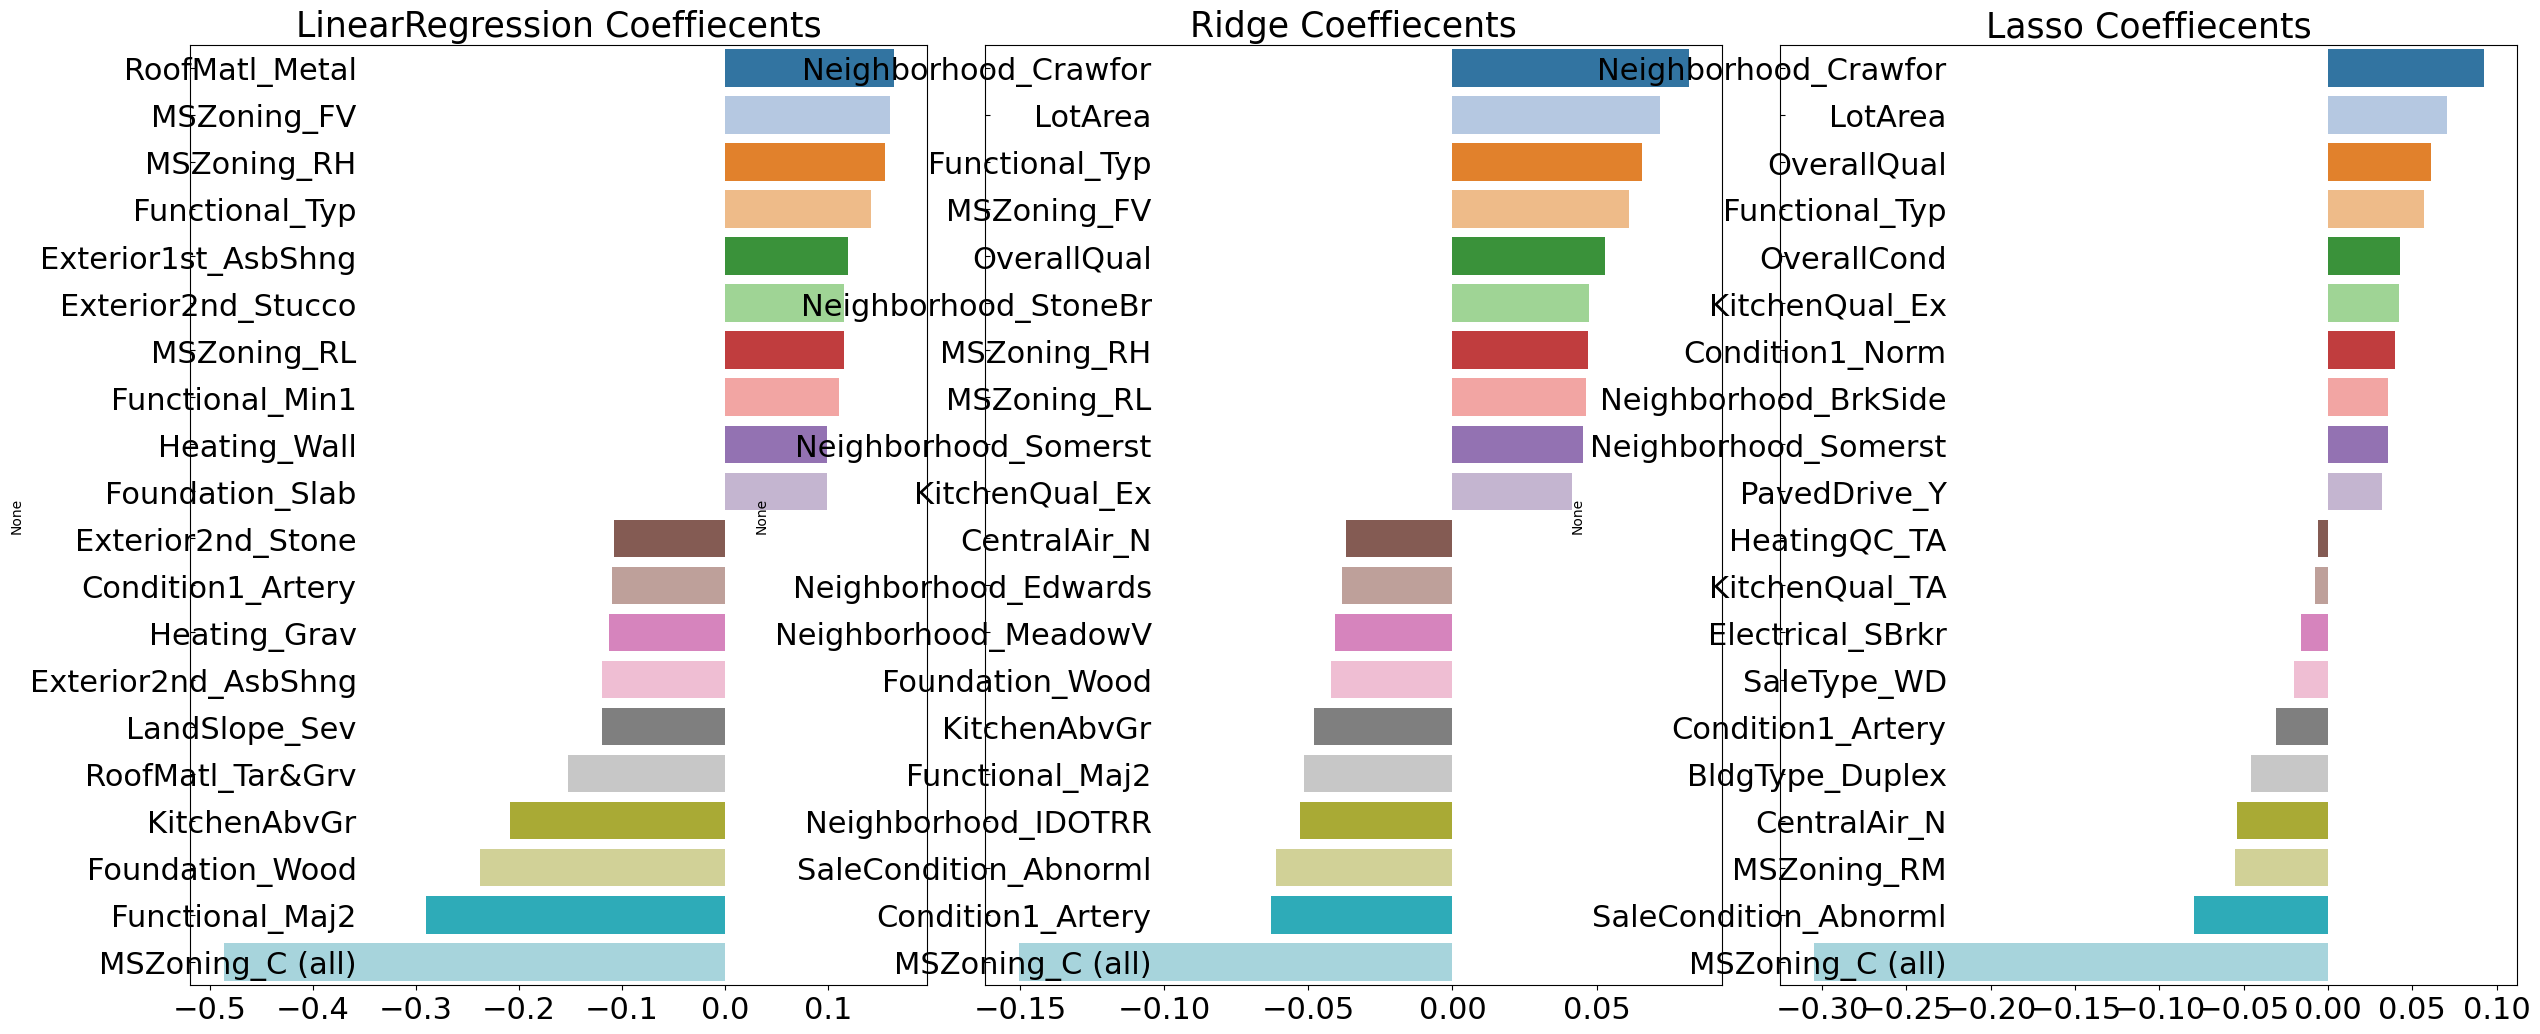

In [140]:
# 최적화 alpha값으로 학습데이터로 학습, 테스트 데이터로 예측 및 평가 수행.
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge(alpha=8)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

# 모든 모델의 RMSE 출력
models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

# 모든 모델의 회귀 계수 시각화
visualize_coefficient(models)

## 2) 회귀 트리 모델

In [141]:
# XGBoost
xgb_params = {'n_estimators':[1000]}
xgb_reg = XGBRegressor(n_estimators=1000, learning_rate=0.05,
                       colsample_bytree=0.5, subsample=0.8)
best_xgb = print_best_params(xgb_reg, xgb_params)

XGBRegressor 5 CV 시 최적 평균 RMSE 값: 0.1209, 최적 alpha:{'n_estimators': 1000}


In [142]:
xgb_reg = XGBRegressor(n_estimators=1000, learning_rate=0.05,
                       colsample_bytree=0.5, subsample=0.8)
xgb_reg.fit(X_train, y_train)

get_rmse(xgb_reg)

XGBRegressor 로그 변환된 RMSE: 0.127
XGBRegressor 로그 변환해제 RMSE: 19541.589


np.float64(19541.58913237069)

In [143]:
# LightGBM
from lightgbm import LGBMRegressor

lgbm_params = {'n_estimators':[1000]}
lgbm_reg = LGBMRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=4,
                         subsample=0.6, colsample_bytree=0.4, reg_lambda=10, n_jobs=-1, verbose=-1)
best_lgbm = print_best_params(lgbm_reg, lgbm_params)

LGBMRegressor 5 CV 시 최적 평균 RMSE 값: 0.1168, 최적 alpha:{'n_estimators': 1000}


In [144]:
lgbm_reg = LGBMRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=4,
                         subsample=0.6, colsample_bytree=0.4, reg_lambda=10, n_jobs=-1, verbose=-1)
lgbm_reg.fit(X_train, y_train)

get_rmse(lgbm_reg)

LGBMRegressor 로그 변환된 RMSE: 0.126
LGBMRegressor 로그 변환해제 RMSE: 19592.939


np.float64(19592.939456147684)

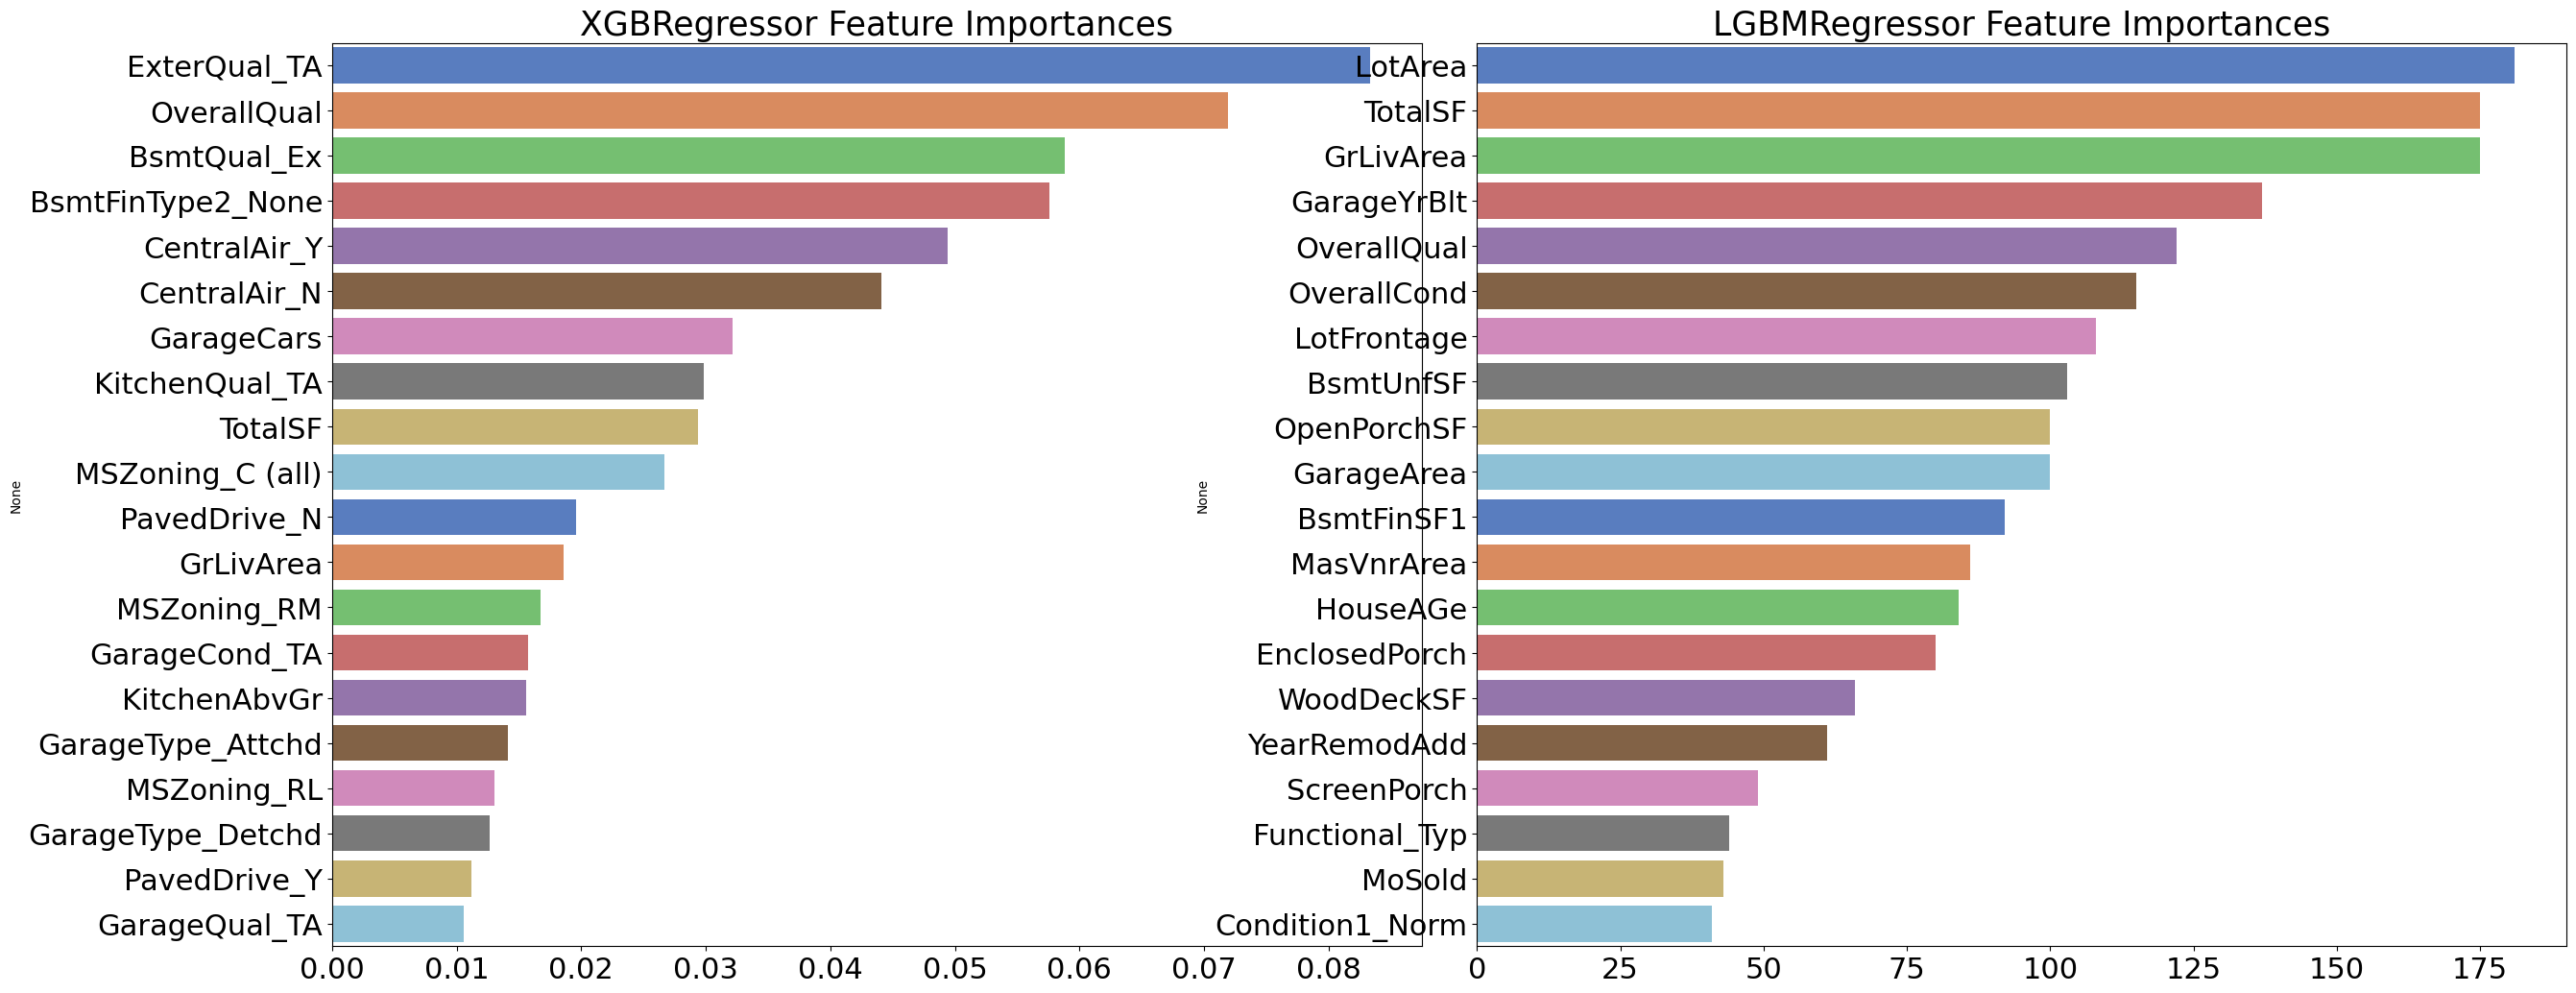

In [145]:
# 모델의 중요도 상위 20개의 피처명과 그때의 중요도값을 Series로 반환.
def get_top_features(model):
    ftr_importances_values = model.feature_importances_
    ftr_importances = pd.Series(ftr_importances_values, index=X_features.columns  )
    ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]
    return ftr_top20

def visualize_ftr_importances(models):
    # 2개 회귀 모델의 시각화를 위해 2개의 컬럼을 가지는 subplot 생성
    fig, axs = plt.subplots(figsize=(24,10),nrows=1, ncols=2)
    fig.tight_layout()
    # 입력인자로 받은 list객체인 models에서 차례로 model을 추출하여 피처 중요도 시각화.
    for i_num, model in enumerate(models):
        # 중요도 상위 20개의 피처명과 그때의 중요도값 추출
        ftr_top20 = get_top_features(model)
        axs[i_num].set_title(model.__class__.__name__+' Feature Importances', size=25)
        #font 크기 조정.
        for label in (axs[i_num].get_xticklabels() + axs[i_num].get_yticklabels()):
            label.set_fontsize(22)
        sns.barplot(x=ftr_top20.values, y=ftr_top20.index , ax=axs[i_num], palette='muted')

# 앞 예제에서 print_best_params( )가 반환한 GridSearchCV로 최적화된 모델의 피처 중요도 시각화
models = [best_xgb, best_lgbm]
visualize_ftr_importances(models)

### 하이퍼 파라미터 튜닝

In [147]:
# XGBoost - run time 오래 걸려서 주석 처리하고 이후 파라미터값 직접 입력
xgb_params = {'n_estimators': [100, 300, 500, 1000],
              'learning_rate': [0.01, 0.05, 0.1],
              'colsample_bytree': [0.3, 0.5, 0.7],
              'subsample': [0.6, 0.8, 1.0]}
xgb_reg = XGBRegressor(n_estimators=1000, learning_rate=0.05,
                       colsample_bytree=0.5, subsample=0.8)
best_xgb = print_best_params(xgb_reg, xgb_params)

XGBRegressor 5 CV 시 최적 평균 RMSE 값: 0.1161, 최적 alpha:{'colsample_bytree': 0.3, 'learning_rate': 0.01, 'n_estimators': 1000, 'subsample': 0.6}


In [ ]:
## best_xgb.fit(X_train, y_train)

best_xgb = XGBRegressor(n_estimators=1000, learning_rate=0.01,
                       colsample_bytree=0.6, subsample=0.4)
best_xgb.fit(X_train, y_train)

get_rmse(best_xgb)

# 튜닝 1; n_estimators=1000, learning_rate=0.01, colsample_bytree=0.3, subsample=0.6 => 0.126 / 19827.741
# 튜닝 2; n_estimators=1000, learning_rate=0.01, colsample_bytree=0.6, subsample=0.4 => 0.124 / 18954.749

XGBRegressor 로그 변환된 RMSE: 0.124
XGBRegressor 로그 변환해제 RMSE: 18954.749


np.float64(18954.74935519766)

In [155]:
lgbm_params = {'n_estimators': [100, 300, 500, 1000],
               'learning_rate': [0.01, 0.05, 0.1],
               'num_leaves': [4, 8, 16, 32]}
            #    'subsample': [0.6, 0.8, 1.0],
            #    'colsample_bytree': [0.3, 0.4, 0.5, 0.7],
            #    'reg_lambda': [0, 1, 10]}
lgbm_reg = LGBMRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=4,
                         subsample=0.6, colsample_bytree=0.4, reg_lambda=10, n_jobs=-1, verbose=-1)
best_lgbm = print_best_params(lgbm_reg, lgbm_params)

LGBMRegressor 5 CV 시 최적 평균 RMSE 값: 0.1164, 최적 alpha:{'learning_rate': 0.05, 'n_estimators': 500, 'num_leaves': 4}


In [182]:
best_lgbm = LGBMRegressor(n_estimators=500, learning_rate=0.05, num_leaves=4,
                         subsample=0.6, colsample_bytree=0.6, reg_lambda=10, n_jobs=-1, verbose=-1)
best_lgbm.fit(X_train, y_train)

get_rmse(best_lgbm)

# 튜닝 1; n_estimators=500, learning_rate=0.05, num_leaves=4, subsample=0.6, colsample_bytree=0.4, reg_lambda=10 => 0.126 / 19432.235
# 튜닝 2; n_estimators=500, learning_rate=0.05, num_leaves=4, subsample=0.6, colsample_bytree=0.6, reg_lambda=10 => 0.125 / 19249.45

LGBMRegressor 로그 변환된 RMSE: 0.125
LGBMRegressor 로그 변환해제 RMSE: 19249.45


np.float64(19249.449543409293)

## 3) 앙상블 모델

In [183]:
# 예측값 혼합 모델
def get_rmse_pred(preds):
    for key in preds.keys():
        pred_value = preds[key]

        # 로그 변환 해제된 예측값과 타겟값
        pred_exp = np.expm1(pred_value)
        y_exp = np.expm1(y_test)

        # 로그 변환 상태
        rmse_log = np.sqrt(mean_squared_error(y_test, pred_value))
        # 로그 변환 해체
        rmse_exp = np.sqrt(mean_squared_error(y_exp, pred_exp))

        print(f'{key} 모델의 로그 변환 RMSE: {rmse_log:.3f}')
        print(f'{key} 모델의 로그 해제 RMSE: {rmse_exp:.3f}')

## 선형 회귀 모델 혼합
# 개별 모델의 학습
ridge_reg = Ridge(alpha=8)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

# 개별 모델 예측
ridge_pred = ridge_reg.predict(X_test)
lasso_pred = lasso_reg.predict(X_test)

# 개별 모델 예측값 혼합으로 최종 예측값 도출
pred = 0.3 * ridge_pred + 0.7 * lasso_pred
preds = {'최종 혼합': pred,
         'Ridge': ridge_pred,
         'Lasso': lasso_pred}
#최종 혼합 모델, 개별모델의 RMSE 값 출력
get_rmse_pred(preds)

최종 혼합 모델의 로그 변환 RMSE: 0.122
최종 혼합 모델의 로그 해제 RMSE: 19377.802
Ridge 모델의 로그 변환 RMSE: 0.121
Ridge 모델의 로그 해제 RMSE: 19093.845
Lasso 모델의 로그 변환 RMSE: 0.124
Lasso 모델의 로그 해제 RMSE: 19708.703


In [184]:
## 회귀 트리 모델 혼합
best_xgb.fit(X_train, y_train)
best_lgbm.fit(X_train, y_train)
xgb_pred = best_xgb.predict(X_test)
lgbm_pred = best_lgbm.predict(X_test)

pred = 0.4 * xgb_pred + 0.6 * lgbm_pred
preds = {'최종 혼합': pred,
         'XGBM': xgb_pred,
         'LGBM': lgbm_pred}

get_rmse_pred(preds)

최종 혼합 모델의 로그 변환 RMSE: 0.123
최종 혼합 모델의 로그 해제 RMSE: 18764.457
XGBM 모델의 로그 변환 RMSE: 0.124
XGBM 모델의 로그 해제 RMSE: 18954.749
LGBM 모델의 로그 변환 RMSE: 0.125
LGBM 모델의 로그 해제 RMSE: 19249.450


In [185]:
## 스태킹 앙상블
# XGBoost + LGBM -> Lasso

# 베이스 모델
base_models = [('xgb', best_xgb),
               ('lgbm', best_lgbm)]

# 메타 모델
meta_model = lasso_reg

# 스태킹 모델
stacking_model = StackingRegressor(
    estimators=base_models,
    final_estimator=meta_model,
    cv=5,
    n_jobs=-1
)

stacking_model.fit(X_train, y_train)
pred = stacking_model.predict(X_test)

rmse_log = np.sqrt(mean_squared_error(y_test, pred))
rmse_exp = np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(pred)))

print(f'스태킹 1의 로그 변환 RMSE: {rmse_log:.3f}')
print(f'스태킹 1의 로그 해제 RMSE: {rmse_exp:.3f}')

스태킹 1의 로그 변환 RMSE: 0.121
스태킹 1의 로그 해제 RMSE: 18484.984


In [186]:
## 스태킹 앙상블
# XGBoost + LGBM + Lasso -> Lasso

# 베이스 모델
base_models = [('xgb', best_xgb),
               ('lgbm', best_lgbm),
               ('lasso', lasso_reg)]

# 메타 모델
meta_model = ridge_reg

# 스태킹 모델
stacking_model = StackingRegressor(
    estimators=base_models,
    final_estimator=meta_model,
    cv=5,
    n_jobs=-1
)

stacking_model.fit(X_train, y_train)
pred = stacking_model.predict(X_test)

rmse_log = np.sqrt(mean_squared_error(y_test, pred))
rmse_exp = np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(pred)))

print(f'스태킹 2의 로그 변환 RMSE: {rmse_log:.3f}')
print(f'스태킹 2의 로그 해제 RMSE: {rmse_exp:.3f}')

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ + self.intercept_
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: invalid value encountered in matmul
  return X @ coef_ + self.intercept_
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ + self

스태킹 2의 로그 변환 RMSE: 0.120
스태킹 2의 로그 해제 RMSE: 18593.734


# 6. 모델별 Score

#####  결측치 제거 + 4개 피처 이상치 제거 + 피처 추가
| 모델 정의 | ML 모델 | 로그 RMSE | 로그 X RMSE | 5 CV 평균 | 
|--------------|--------|------|-------|-------|
| 기본 | LinearRegression | 0.118 | 19881.627 | 0.129 | 
| 기본 | Ridge | 0.114 | 19359.912 | 0.115 | 
| 기본 | Lasso | 0.158 | 26363.696 | 0.171 |  
| 튜닝 | Ridge | 0.109 | 18176.214 | 0.1136 | 
| 튜닝 | Lasso | 0.107 | 17744.352 | 0. 112 |
| 기본 | XGBoost | 0.114 | 19187.518 | 0. 1205 |
| 기본 | LightGBM | 0.105 | 17314.155 | 0.1164 |
| 튜닝1 | XGBoost | 0.11 | 18213.235 | 0. 1174 |
| 튜닝1 | LightGBM | 0.107 | 17082.242 | 0.1163 |
| 튜닝2 | XGBoost | 0.109 | 17865.572 | - |
| 튜닝2 | LightGBM | 0.104 | 17127.629 | - |
| 혼합 | Ridge + Lasso | 0.106 | 17661.678 | - |
| 혼합 | XGB + LGBM | 0.103 | 16908.632 | - | 
| 스태킹1 | XGBoost + LGBM -> Lasso | 0.107 | 17942.170 | - |
| 스태킹2 | XGBoost + LGBM + Lasso -> Ridge | 0.102 | 16679.046 | - |

##### 결측치 제거 + 4개 피처 이상치 제거 + 피처 추가 + 기존 피처 제거
| 모델 정의 | ML 모델 | 로그 RMSE | 로그 X RMSE | 5 CV 평균 | 
|--------------|--------|------|-------|-------|
| 기본 | LinearRegression | 0.117 | 19776.997 | 0.128 | 
| 기본 | Ridge | 0.112 | 19181.079 | 0.115 | 
| 기본 | Lasso | 0.159 | 26436.752 | 0.171 |  
| 튜닝 | Ridge | 0.108 | 18090.616 | 0.113 | 
| 튜닝 | Lasso | 0.107 | 17756.612 | 0.1116 |
| 기본 | XGBoost | 0.113 | 18409.738 | 0. 1188 |
| 기본 | LightGBM | 0.107 | 17143.845 | 0.1167 |
| 튜닝1 | XGBoost | 0.11 | 17996.859 | 0. 1158 |
| 튜닝1 | LightGBM | 0.108 | 17441.071 | 0.1163 |
| 튜닝2 | XGBoost | 0.108 | 17481.418 | - |
| 튜닝2 | LightGBM | 0.106 | 16986.832 | - |
| 혼합 | Ridge + Lasso | 0.106 | 17658.185 | - |
| 혼합 | XGB + LGBM | 0.104 | 16711.335 | - | 
| 스태킹1 | XGBoost + LGBM -> Lasso | 0.107 | 17672.712 | - |
| 스태킹2 | XGBoost + LGBM + Lasso -> Ridge | 0.102 | 16604.646 | - |

##### 결측치 제거 + GrLivArea에서만 이상치 제거 + 피처 추가 + 기존 피처 제거

# 7. 최종 제출

In [187]:
print(train_processed.shape)
print(test_processed.shape)

(1138, 265)
(292, 265)


In [188]:
## sample_data를 받아오기
sample = pd.read_csv('./data/HousePrices_sample_submission.csv')

# SalePrice 가 0으로 차있는 sample
sample

,Id,SalePrice
0,86,0
1,227,0
2,492,0
3,64,0
4,576,0
...,...,...
287,1271,0
288,903,0
289,1019,0
290,312,0


In [189]:
if 'SalePrice' in test_processed.columns:
    print("SalePrice 컬럼이 있습니다.")
else:
    print("SalePrice 컬럼이 없습니다.")

SalePrice 컬럼이 있습니다.


In [190]:
if 'SalePrice' in test_processed.columns:
    test_processed = test_processed.drop(columns=['SalePrice'])

In [194]:
best_lgbm.fit(X_train, y_train)

pred = best_lgbm.predict(test_processed)
pred_exp = np.expm1(pred)

# sample 파일에 예측 값을 넣어주고
sample["SalePrice"] = pred_exp

# csv로 저장하기
sample.to_csv("./HousePrices_submission10.csv", index=False)

In [195]:
# 제출부분과 크기가 맞는지 확인
pred_exp.shape

(292,)

In [196]:
pred_exp

array([279036.45755299, 281907.43468806, 151879.71331557, 144588.53409559,
       116273.11809835, 293574.20132265, 241215.95583   ,  85991.9338249 ,
       170980.98922956, 140961.24311435, 321255.29110599, 221018.65176103,
        76005.2483078 ,  80641.91458972, 146404.20053205, 140198.97118741,
       131164.99406902, 281167.56755251, 233898.70992853, 117590.32572194,
       239981.77796518, 157871.93162117, 144479.96088889, 222936.50574154,
       119939.75160394, 191061.66933094, 146887.77854282, 156452.04245548,
       320839.0479789 , 189632.93196108, 207226.50638323, 179914.13119259,
       159372.87711667, 164307.16726346, 184665.69674928, 362809.53691475,
       110965.89155493, 208796.76405032, 262212.21233101, 135002.65348225,
       320632.35588834, 195830.25122693, 127031.66208722, 319404.81497971,
       126211.42115261, 167807.44020982, 129615.21177601, 147537.39949899,
       213325.54438292, 168815.15451966, 182507.53847336, 143910.28352772,
       222903.7045158 , 1

- 1차 제출 스태킹 모델: 32536.67757
- 2차 제출 1차 튜닝한 LigtGBM: 25807.23643
- 3차 제출 XGBoost + LightGBM: 25518.81761
- 4차/5차 스태킹 모델 - 과적합 폭주..수치 추정
- 6차 LightGBM: 23786.89676
- 7차 XGBoost + LightGBM: 24236.19152
- 8차 LightGBM(이상치 책 따라 제거): 61857.95300
- 9차 XGBoost:
- 10차 LightGBM: 